In [1]:
import matplotlib.pyplot as plt
import optimization
import oracles
import utils
from plot_trajectory_2d import plot_trajectory, plot_levels
from optimization import gradient_descent, newton
import numpy as np
from random import seed

import warnings
warnings.filterwarnings('ignore')

np.random.seed(10)
seed(10)
plt.rcParams["figure.figsize"] = (14, 7)

# Эксперимент 1

In [2]:
def plot_levels(func, xrange=None, yrange=None, levels=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]

    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = ax.contour(X, Y, Z, levels=levels, colors='k')
    ax.clabel(CS, inline=1, fontsize=8)
    ax.grid()


def plot_trajectory(func, history, fit_axis=False, label=None, color='red', ax=None):
    if ax is None:
        ax = plt.gca()
    x_values, y_values = zip(*history)
    ax.plot(x_values, y_values, '-v', linewidth=2.5, ms=9.0,
             alpha=1.0, label=label, color=color)

    # Tries to adapt axis-ranges for the trajectory:
    if fit_axis:
        xmax, ymax = np.max(x_values), np.max(y_values)
        COEF = 1.5
        xrange = [-xmax * COEF, xmax * COEF]
        yrange = [-ymax * COEF, ymax * COEF]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)

In [3]:
def cond_f(oracle, x):
    return np.linalg.norm(oracle.grad(x)) / np.linalg.norm(oracle.func(x)) * np.linalg.norm(x)

def cond(A):
    return np.linalg.cond(A)

In [4]:
levels_ = [0, 10, 16, 25, 50, 75, 100, 125, 150]
colordict = {0:'blue', 1:'lime'}
def plot_f(orcl, Xs_list, Ab_ind, cond_A, xrg=[-5, 5], yrg=[-6, 7]):
    """
        plot all methods for one function from one point
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
    for ax in axes:
        plot_levels(orcl.func, xrange=xrg, yrange=yrg, levels=levels_, ax=ax)
    for ci, X in enumerate(Xs_list):
        _, _, history_c = gradient_descent(orcl, X, trace=True, 
                                                   line_search_options=utils.LineSearchTool(method='Constant', c=0.05))
        _, _, history_a = gradient_descent(orcl, X, trace=True, 
                                                   line_search_options=utils.LineSearchTool(method='Armijo'))
        _, _, history_w = gradient_descent(orcl, X, trace=True, 
                                                   line_search_options=utils.LineSearchTool(method='Wolfe'))
        
        history = {
            'Constant':history_c['x'],
            'Armijo':history_a['x'],
            'Wolfe':history_w['x']
        }
        for iax, method in enumerate(['Constant', 'Armijo', 'Wolfe']):
            plot_trajectory(orcl.func, history[method], label='Start point: {0}'.format(X), color=colordict[ci], ax=axes[iax])

    for iax, method in enumerate(['Constant', 'Armijo', 'Wolfe']):
        axes[iax].set_title(method + '. Cond. {:.3}'.format(cond_A))
        axes[0].set_ylabel('Function {0}'.format(Ab_ind + 1))
        axes[iax].legend()
#     fig.savefig('gph_{0}.png'.format(Ab_ind))    

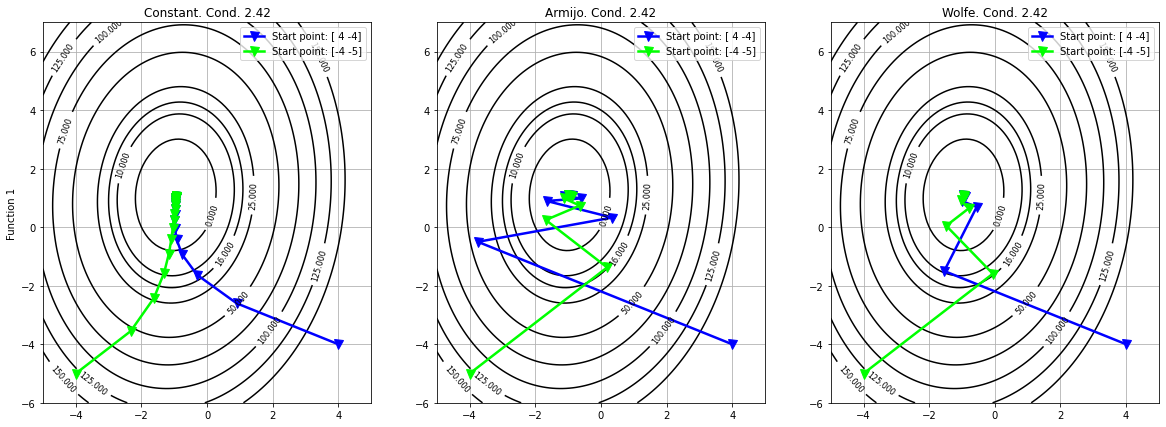

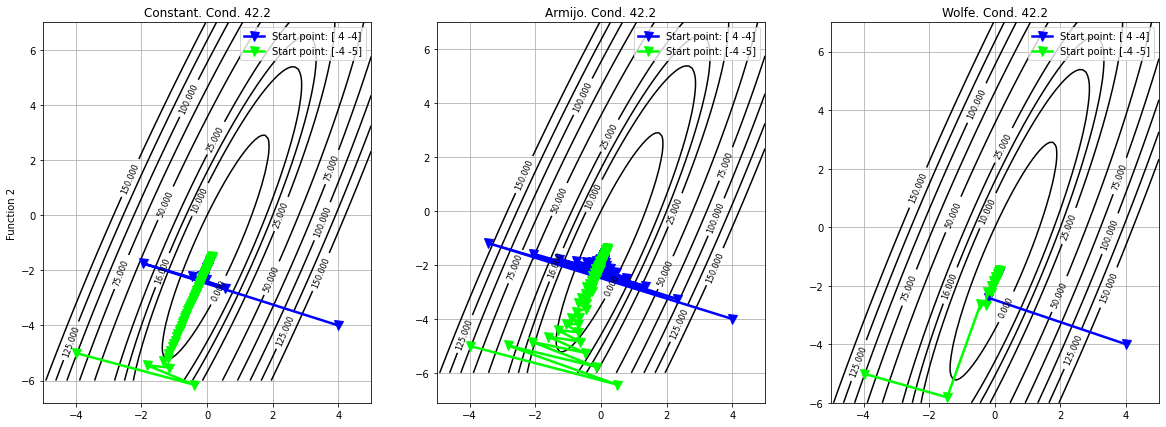

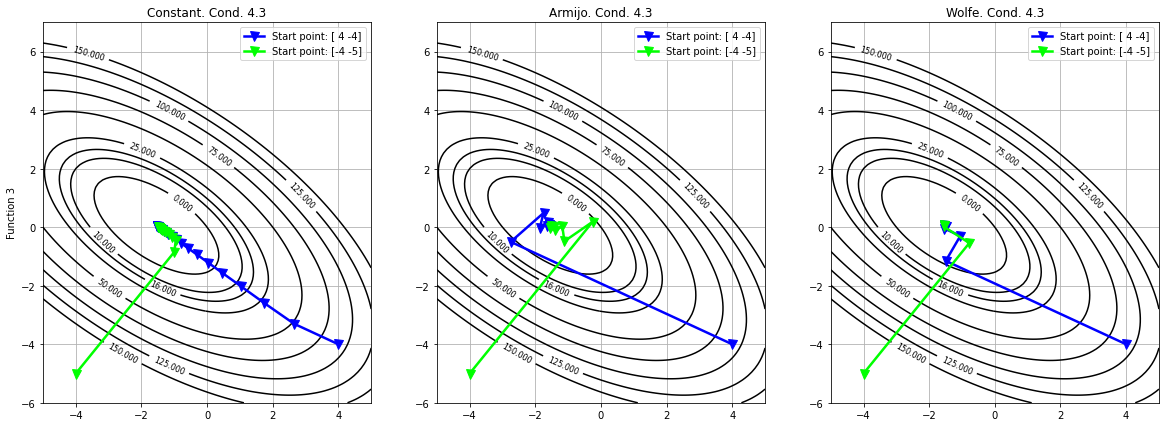

In [5]:
A_1 = np.array([[12, -0.5], [-0.5, 5]])
A_2 = np.array([[25, -9], [-9, 4]])
A_3 = np.array([[10, 7], [7, 13]])

b_1 = np.array([-12, 6])
b_2 = np.array([17, -7])
b_3 = np.array([-15, -10])

x_1 = np.array([4, -4])
x_2 = np.array([-4, -5])
points = [x_1, x_2]

cond_1 = []
cond_2 = []
for Ab_ind, [A, b] in enumerate([[A_1, b_1], [A_2, b_2], [A_3, b_3]]):
    orcl = oracles.QuadraticOracle(A, b)
    cond_1.append(cond_f(orcl, points[0]))
    cond_2.append(cond_f(orcl, points[1]))
    plot_f(orcl, points, Ab_ind, cond(A))
    plt.grid(True)
    plt.show()

# Эксперимент 2

### $x$ близок к нулю.

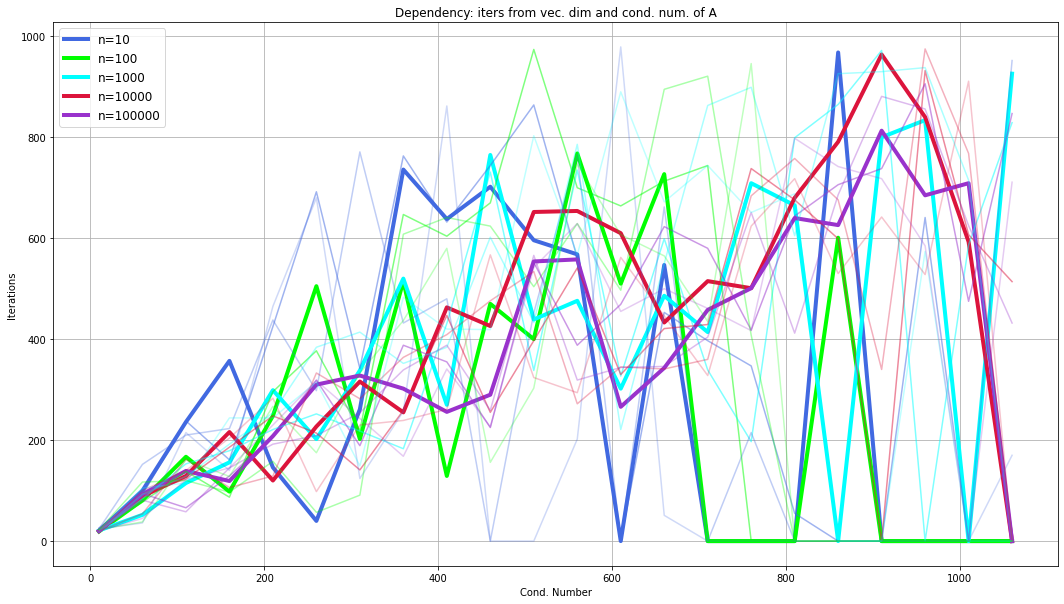

In [7]:
from scipy import sparse
np.random.seed(10) # на всякий

def generate(n, k):
    a = np.random.uniform(1, k, n)
    ind_1 = np.random.choice(n)
    a[ind_1] = 1
    while True:
        ind_2 = np.random.choice(n)
        if ind_2 != ind_1:
            break
    a[ind_2] = k
    A = sparse.diags(a)
    b = np.random.randint(-k, k, n)
    return A, b

N = 6
n_degrees = range(1, N)
K = 1070
k_step = 50
ks = range(10, K, k_step)
colorlist = ['royalblue', 'lime', 'cyan', 'crimson', 'darkorchid', 'red', 'midnightblue']
assert len(colorlist) >= N
fig = plt.figure(figsize=(18, 10))
for rep in range(1, 5):

    for_each_n = []
    for deg in n_degrees:
        n = 10 ** deg
        forn_k_iters = []
        for k in ks:
            A, b = generate(n, k)
            orcl = oracles.QuadraticOracle(A, b)
            x_start = np.random.uniform(-0.05, 0.05, n)
            _, msg, history = gradient_descent(orcl, x_start, trace=True, max_iter=1000)
            if msg == 'success':
                forn_k_iters.append(len(history['time']) - 1)
            else:
                forn_k_iters.append(0)
        for_each_n.append(forn_k_iters)
        if rep == 1:
            plt.plot(ks, for_each_n[deg-1], label='n={0}'.format(10 ** deg), color=colorlist[deg-1], linewidth=4)
        else:
            plt.plot(ks, for_each_n[deg-1], color=colorlist[deg-1], alpha=1/rep)

plt.grid()
plt.legend(fontsize='large')
plt.title('Dependency: iters from vec. dim and cond. num. of A')
plt.xlabel('Cond. Number')
plt.ylabel('Iterations')
plt.show()
# fig.savefig('gph_3.png') 

### $x$ далеко от нуля.

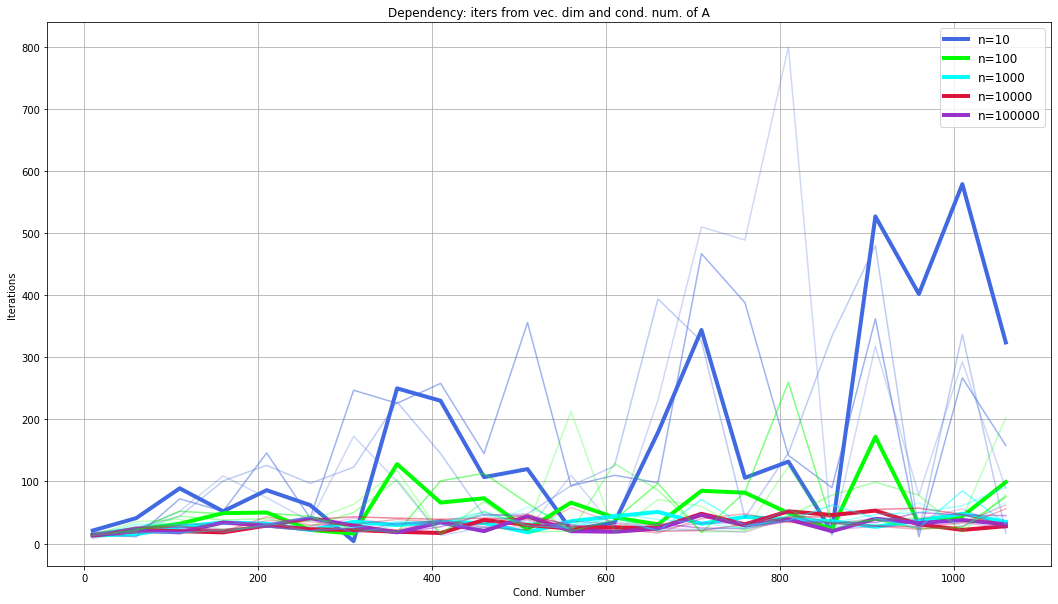

In [8]:
N = 6
n_degrees = range(1, N)
K = 1070
k_step = 50
ks = range(10, K, k_step)
colorlist = ['royalblue', 'lime', 'cyan', 'crimson', 'darkorchid', 'red', 'midnightblue']
assert len(colorlist) >= N
fig = plt.figure(figsize=(18, 10))
for rep in range(1, 5):

    for_each_n = []
    for deg in n_degrees:
        n = 10 ** deg
        forn_k_iters = []
        for k in ks:
            A, b = generate(n, k)
            orcl = oracles.QuadraticOracle(A, b)
            x_start = np.random.uniform(-50, 50, n)
            _, msg, history = gradient_descent(orcl, x_start, trace=True, max_iter=1000)
            if msg == 'success':
                forn_k_iters.append(len(history['time']) - 1)
            else:
                forn_k_iters.append(0)
        for_each_n.append(forn_k_iters)
        if rep == 1:
            plt.plot(ks, for_each_n[deg-1], label='n={0}'.format(10 ** deg), color=colorlist[deg-1], linewidth=4)
        else:
            plt.plot(ks, for_each_n[deg-1], color=colorlist[deg-1], alpha=1/rep)

plt.grid()
plt.legend(fontsize='large')
plt.title('Dependency: iters from vec. dim and cond. num. of A')
plt.xlabel('Cond. Number')
plt.ylabel('Iterations')
plt.show()
# fig.savefig('gph_4.png') 

# Эксперимент 3

* [dataset1 - Wine Quality](https://www.kaggle.com/nareshbhat/wine-quality-binary-classification)
* [dataset2 - Fraud Detection](https://www.kaggle.com/volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary)
* [dataset3 - Hospital Readmissions](https://www.kaggle.com/omnamahshivai/dataset-hospital-readmissions-binary)

In [47]:
import random
random.seed(10)
dataset1 = pd.read_csv('data/wine.csv')
dataset2 = pd.read_csv('data/fraud.csv')
dataset3 = pd.read_csv('data/hospital.csv')

dataset1.shape[0], dataset2.shape[0], dataset3.shape[0]

(1599, 20468, 59557)

In [49]:
y1 = (dataset1.quality == 'good').astype(int).to_numpy()
y2 = dataset2.targets.to_numpy()
y3 = dataset3.readmitted.to_numpy()[:35000]
y1[np.argwhere(y1 == 0)] = -1
y2[np.argwhere(y2 == 0)] = -1
y3[np.argwhere(y3 == 0)] = -1

X1 = dataset1.drop(columns=['quality']).to_numpy()
X2 = dataset2.drop(columns=['targets']).to_numpy()
X3 = dataset3.drop(columns=['readmitted']).to_numpy()[:35000]

class Dataset():
    def __init__(self, xtrain, xval, ytrain, yval):
        assert xtrain.shape[1] == xval.shape[1]
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval
        self.d = xtrain.shape[1]
        
    def train(self):
        return [self.xtrain, self.ytrain]
    
    def val(self):
        return [self.xval, self.xval]
    
    def train_len(self):
        return len(self.ytrain)
    
    def val_len(self):
        return len(self.yval)

In [50]:
from sklearn.model_selection import train_test_split
dataset1 = Dataset(*train_test_split(X1, y1, test_size=0.25, random_state=10, stratify=y1))
dataset2 = Dataset(*train_test_split(X2, y2, test_size=0.25, random_state=10, stratify=y2))

X3, _, y3, _ = train_test_split(X3, y3, test_size=0.3, random_state=10, stratify=y3)
dataset3 = Dataset(*train_test_split(X3, y3, test_size=0.25, random_state=10, stratify=y3))

In [51]:
from tqdm.notebook import tqdm
tolerances = np.logspace(-8, 0, num=18)

ds_errors = [] 
for ds in tqdm([dataset1, dataset2, dataset3]):
    for_ds_err = []
    for eps in tqdm(tolerances):
        start_x = np.zeros(ds.d)
        orcl = oracles.create_log_reg_oracle(ds.xtrain, ds.ytrain, regcoef=1/ds.train_len())
        x_hat, msg, _ = newton(orcl, start_x, tolerance=eps, max_iter=500)
        
        if msg == 'success':
            b_hat = ds.xval @ x_hat
            err = np.sum(np.sign(ds.yval * b_hat) == -1) / ds.val_len()
            for_ds_err.append(err)
        else:
            for_ds_err(None)
    ds_errors.append(for_ds_err)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

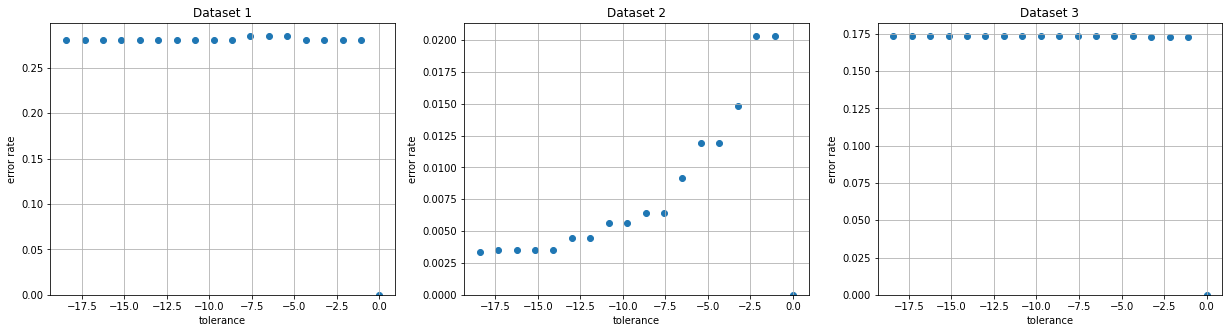

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 5))
for i in range(3):
    axes[i].scatter(np.log(tolerances), ds_errors[i])
    axes[i].set_title('Dataset {0}'.format(i + 1))
    axes[i].set_xlabel('tolerance')
    axes[i].set_ylabel('error rate')
    axes[i].set_ylim(0)
    axes[i].grid()

plt.show()
# fig.savefig('gph_5.png') 

Проверка второго датасета:

In [53]:
from sklearn.linear_model import LogisticRegression as LogReg
model = LogReg(solver='newton-cg', tol=1e-12).fit(dataset2.xtrain, dataset2.ytrain)
1 - accuracy_score(dataset2.yval, model.predict(dataset2.xval))

0.01700214969708813

# Эксперимент 4

In [ ]:
assert 2 == 3

In [ ]:
import zipfile
import wget
import os
    
filenames = ['w8a', 'gisette_scale.bz2', 'real-sim.bz2', 'news20.binary.bz2', 'rcv1_train.binary.bz2']
for filename in filenames:
    wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/' + filename, filename)
    os.replace(filename, 'data/' + filename)
    filename = 'data/' + filename.split('.')[0]

In [ ]:
from libsvm.svmutil import *
from sklearn.datasets import load_svmlight_file
for i in range(len(filenames)):
    filenames[i] = 'data/' + filenames[i].split('.')[0]

In [ ]:
descends = {0:'GD', 1:'Newton GD'}
colorlist = {0:'royalblue', 1:'lime'}

for ds_num, dataset in tqdm(enumerate(filenames)):
    fig, axes = plt.subplots(1, 3)
    X, y = load_svmlight_file(dataset)

    start_x = np.zeros(X.shape[1])
    orcl = oracles.create_log_reg_oracle(X, y, regcoef=1/len(y))
    
    for gd in range(2):
        if gd == 0:
            _, _, history = gradient_descent(orcl, start_x, trace=True)
        else:
            _, _, history = newton(orcl, start_x, trace=True)
        
        norm_0 = history['grad_norm'][0] ** 2
        axes[0].plot(range(len(history['func'])), history['func'],
                     label='descend: {}'.format(descends[gd]), color=colorlist[gd])
        axes[1].plot(history['time'], history['func'],
                     label='descend: {}'.format(descends[gd]), color=colorlist[gd])
        axes[2].plot(history['time'], np.log(np.asarray(history['grad_norm']) ** 2 / norm_0),
                     label='Method: {}'.format(descends[gd]), color=colorlist[gd])
        
    axes[0].set(title='Function value - Descend iterations (Dataset {0})'.format(ds_num),
              ylabel='func val', xlabel='Iters')
    
    axes[1].set(title='Function value - Time (Dataset {0})'.format(ds_num),
              ylabel='funct val', xlabel='time')
    
    axes[2].set(title='Grad. norms quotient - Time (Dataset {0})'.format(ds_num),
              ylabel='grad norms quotient', xlabel='time')
    plt.grid()
    plt.show()
#     fig.savefig('gph_{0}.png'.format(6 + ds_num)) 

На этих датасетах ничего не работает, и оперативная память кончается на первом же датасете. Мне посоветовали провести эсперимент на других данных.

10001
4
188
8
16
4


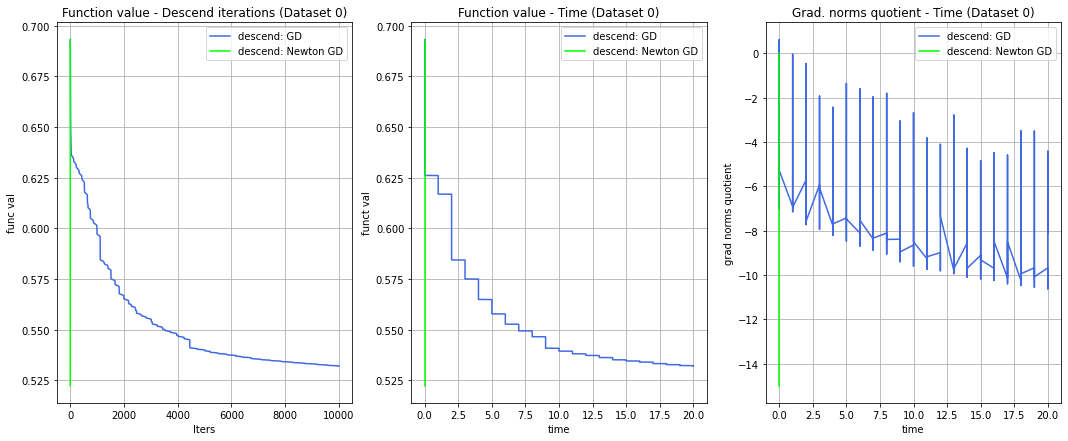

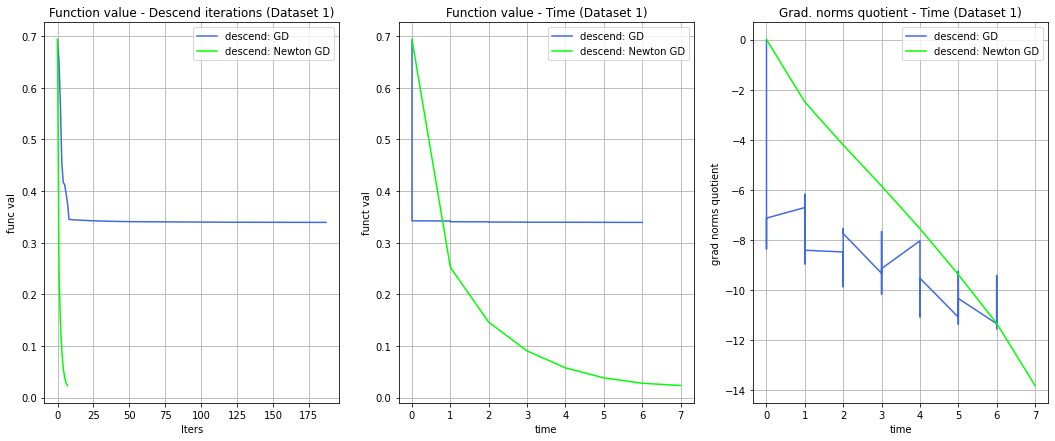

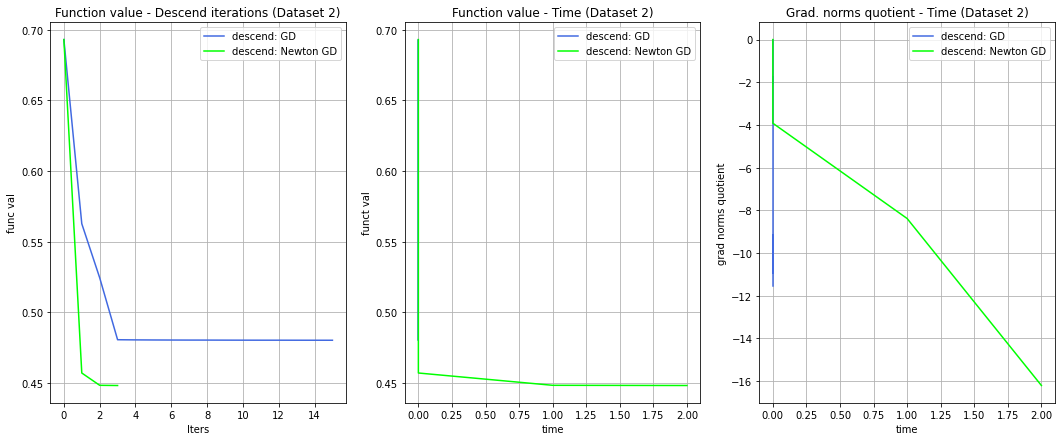

In [54]:
descends = {0:'GD', 1:'Newton GD'}
colorlist = {0:'royalblue', 1:'lime'}

for ds_num, ds in enumerate([dataset1, dataset2, dataset3]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))

    start_x = np.zeros(ds.d)
    orcl = oracles.create_log_reg_oracle(ds.xtrain, ds.ytrain, regcoef=1/ds.train_len())
    
    for gd in range(2):
        if gd == 0:
            _, _, history = gradient_descent(orcl, start_x, trace=True)
        else:
            _, _, history = newton(orcl, start_x, trace=True)
        
        norm_0 = history['grad_norm'][0] ** 2
        print(len(history['func']))
        axes[0].plot(range(len(history['func'])), history['func'],
                     label='descend: {}'.format(descends[gd]), color=colorlist[gd])
        axes[1].plot(history['time'], history['func'],
                     label='descend: {}'.format(descends[gd]), color=colorlist[gd])
        axes[2].plot(history['time'], np.log(np.asarray(history['grad_norm']) ** 2 / norm_0),
                     label='descend: {}'.format(descends[gd]), color=colorlist[gd])
        
    axes[0].set(title='Function value - Descend iterations (Dataset {0})'.format(ds_num),
              ylabel='func val', xlabel='Iters')
    
    axes[1].set(title='Function value - Time (Dataset {0})'.format(ds_num),
              ylabel='funct val', xlabel='time')
    
    axes[2].set(title='Grad. norms quotient - Time (Dataset {0})'.format(ds_num),
              ylabel='grad norms quotient', xlabel='time')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()
#     fig.savefig('gph_{0}.png'.format(6 + ds_num)) 
plt.show()